# Ce code à pour objectif de proposer un piste de recherche pour l'automatisation de la base de données du CHUL
<p>Objectifs: </p>
<li> Mettre en place une méthode permettant d'extraire l'information utile sur chaque image sans degrader son contenu </li>
<li>Les contraintes principales réside dans l'hétérogenité des données </li>
<li> Les images en sortie doivent être en tableau de 128*128*128*2 (2 cannaux d'entré)

## Bibliothèques utiles

In [174]:
################# Bibliothèque pour traiter les fichiers DICOM ######################

import pydicom as dicom
from sklearn.preprocessing import  StandardScaler
scaler = StandardScaler()
import glob
import numpy as np
import skimage
from skimage.transform import resize
import cv2 
################# Bibliothèque pour l'affichage #######################################
import matplotlib.pyplot as plt


## Exemple sur un Patient test

### Récupération d'un patient et de ses caractéritiques

(264, 326, 330)
(264, 326, 330)
Le flair et le T1 ont les même caractéristiques: True


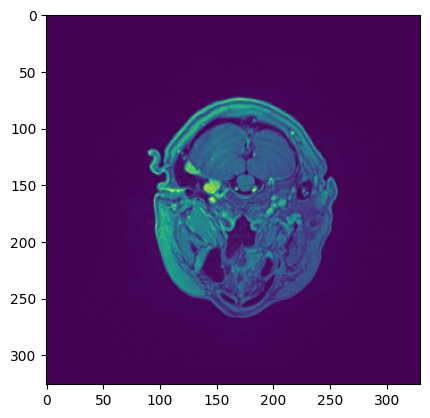

In [175]:

################# Chemin de l'image##################

image_path = '/Users/bimlaboratoire/python/stage_mzoughebi/Database/DataBase_IA/patient_55/'

######### récupération de l'image sous forme de tableau numpy#############

t1_dicom = dicom.dcmread(image_path + 't1_ce.dcm')
t1=t1_dicom.pixel_array

flair_dicom = dicom.dcmread(image_path + 'flair.dcm')
flair=flair_dicom.pixel_array

# Caractéristiques des images
print(t1.shape)
print(flair.shape)
print('Le flair et le T1 ont les même caractéristiques: ' + str(t1.shape==flair.shape))
plt.imshow(t1[190,:,:])

### Normalisation pour recentrer les valeurs 


In [176]:
########## On affiche les caractéristiques avant modification ##########
print('maximum sans rescale : ' + str(flair.max()))
############ Nécessite de Rescale les values ########

# Obligé de rescale sur des volumes 1D d'ou on décompose en 1D puis on recompose en 3D
flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

########## On fait pareil avec le t1 #####################################
t1 = scaler.fit_transform(t1.reshape(-1, t1.shape[-1])).reshape(t1.shape)


#On vérifie les modifications éffectuées 
print('maximum avec rescale : ' + str(flair.max()))

# Affichage des statistiques après la standardisation
print('moyenne: ' + str(flair.mean()))
print('écart type : ' + str(flair.std()))

maximum sans rescale : 32767
maximum avec rescale : 186.6852256395332
moyenne: 4.838705284787693e-17
écart type : 0.8563488385776551


### Affichage du patient avant le traitement réalisé

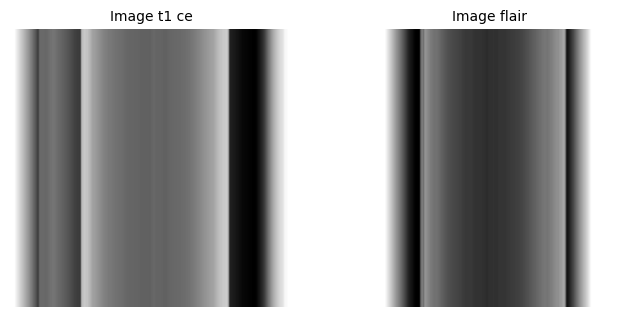

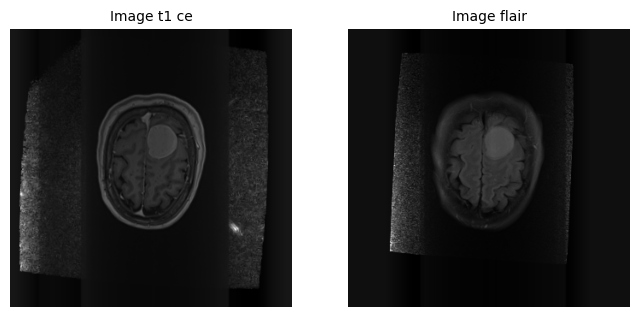

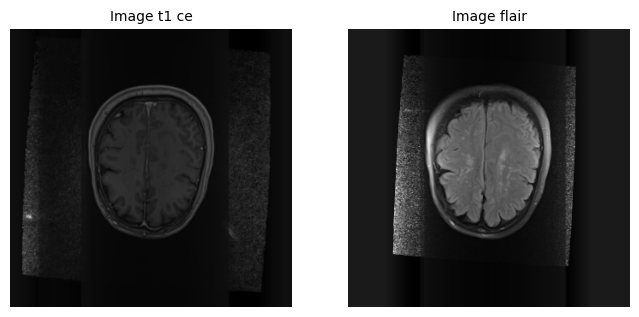

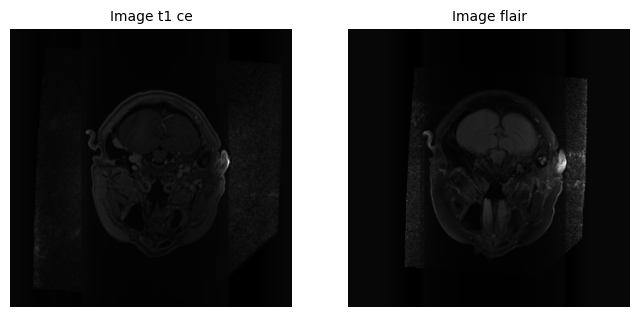

In [177]:
slice=[0,80, 100,188]
for n_slice in slice:
    # Création d'une figure avec 1 ligne et 2 colonnes
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))

    # Affichage de l'image t1
    axs[0].imshow(t1[n_slice,:,:], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Image t1 ce" ,fontsize=10)

    # Affichage de l'image flair
    
    axs[1].imshow(flair[n_slice,:,:], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Image flair", fontsize=10)


    # Affichage du tableau avec les deux cellules
    plt.show()

### Detection par contour actif
<li> L'iddée est de trouver une méthode permettant de sélectionner une zone d'interet sur le patient selon les trois dimensions</li>
<li>On commence par utiliser un snake pour savoir la zone de pixel que nous allons garder</li>

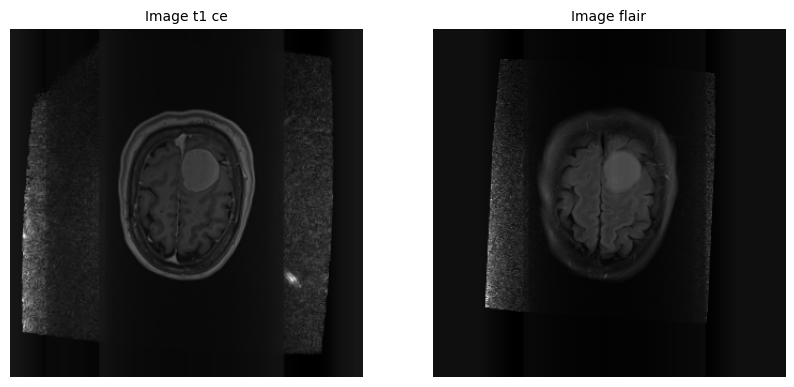

In [178]:
 size=80
# size=98
slice=[size]
for n_slice in slice:
    # Création d'une figure avec 1 ligne et 2 colonnes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Affichage de l'image t1
    axs[0].imshow(t1[n_slice,:,:], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Image t1 ce" ,fontsize=10)

    # Affichage de l'image flair
    
    axs[1].imshow(flair[n_slice,:,:], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Image flair", fontsize=10)


    # Affichage du tableau avec les deux cellules
    plt.show()

In [179]:

# Normalisation pour mettre les valeurs entre 0 et 255 (src,destination,min,max,lineaire)
normalized_image = cv2.normalize(flair[size,:,:], None, 0, 255, cv2.NORM_MINMAX)


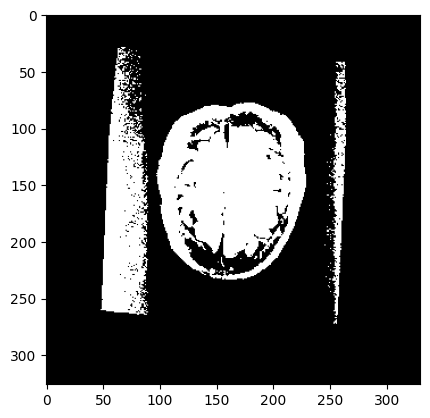

In [180]:

# Appliquer le seuillage binaire (src,seuil,max,binaire)== ret = seuil, tresh = image_seuil
ret, thresh = cv2.threshold(normalized_image, 22, 255, cv2.THRESH_BINARY)

### On visualise les image binaire ###

# Afficher l'image seuillée
plt.imshow(thresh, cmap='gray')

In [181]:
# Convertir l'image seuillée en type CV_8UC1
thresh = thresh.astype(np.uint8)
# Detection des contours
# contours == liste des contours, hierarchy = liste de la hierarchie des contours
# src, hierarchy basé sur les relations parents enfants, pas d'appproximatiom sur le contours
contours, hierarchy = cv2.findContours( thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
print(len(hierarchy))
print(len(contours))
# Créer une image noire de la même taille que l'image originale
image_black = np.zeros_like(flair[size,:,:], dtype=np.uint8)



1
385


[0 1]


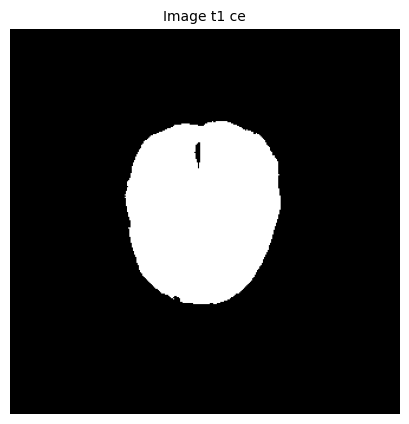

2


In [182]:
# Filtrer les contours ayant une longueur de plus de 30 pixels et une forme circulaire
filtered_contours = []
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    if perimeter > 0:  # Vérifier que la circonférence est non nulle
        area = cv2.contourArea(contour)
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if len(contour) > 40 and circularity > 0.4:  # Ajustez la valeur de circularité selon vos besoins
            filtered_contours.append(contour)

# Dessiner les contours sur l'image noire
cv2.drawContours(image=image_black, contours=filtered_contours, contourIdx=-1, color=1, thickness=cv2.FILLED, lineType=cv2.LINE_AA)

# Création d'une figure avec 1 ligne et 1 colonnes
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
print(np.unique(image_black))
# Affichage de l'image t1
axs.imshow(image_black, cmap='gray')
axs.axis('off')
axs.set_title("Image t1 ce" ,fontsize=10)
plt.show()

print(len(filtered_contours))


(326, 330)
(326, 330)


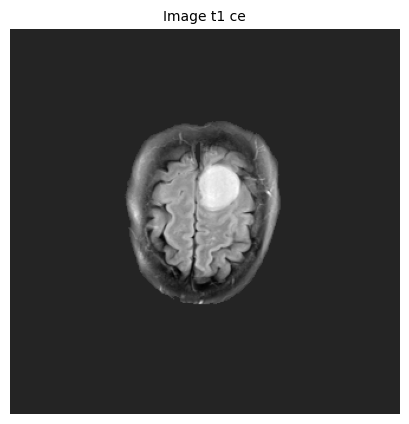

In [183]:
# Dimension d'origine
print(image_black.shape)
print(flair[size,:,:].shape)
# Appliquer le masque à l'image en utilisant un bitwise AND
resultat = cv2.bitwise_and(flair[size,:,:], flair[size,:,:], mask=image_black[:,:])
# Création d'une figure avec 1 ligne et 1 colonnes
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
# Affichage de l'image t1
axs.imshow(resultat, cmap='gray')
axs.axis('off')
axs.set_title("Image t1 ce" ,fontsize=10)
plt.show()


### Redimensionnement de l'image

In [184]:
# Trouver les indices des pixels non nuls
indices_non_nuls = np.transpose(np.nonzero(resultat))

# Vérifier si le tableau indices_non_nuls est vide
if indices_non_nuls.shape[0] == 0:
    # Utiliser les dimensions d'origine de l'image
    ymin, ymax, xmin, xmax = 0, resultat.shape[0], 0, resultat.shape[1]
else:
    # Calculer les indices min et max selon l'axe x et y des pixels non nuls
    xmin = np.min(indices_non_nuls[:, 1])
    xmax = np.max(indices_non_nuls[:, 1])
    ymin = np.min(indices_non_nuls[:, 0])
    ymax = np.max(indices_non_nuls[:, 0])


# Afficher les indices min et max
print("Indice min selon l'axe x:", xmin)
print("Indice max selon l'axe x:", xmax)
print("Indice min selon l'axe y:", ymin)
print("Indice max selon l'axe y:", ymax)

Indice min selon l'axe x: 97
Indice max selon l'axe x: 228
Indice min selon l'axe y: 78
Indice max selon l'axe y: 232


(154, 131)


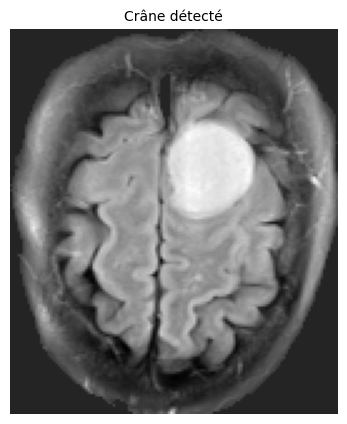

In [185]:

# Dessiner le crâne détecté en blanc sur fond noir
crane_detecte = resultat[ymin:ymax, xmin:xmax]

#On va gerer le cas des premieres slides qui sont reconnaissable avec une très faible diminution selon l'axe y

if ymax-ymin > (flair.shape[1]*0.80) or xmax-xmin<(flair.shape[1]*0.2) :
    crane_detecte = np.zeros_like(flair[size,:,:], dtype=np.uint8)

# Afficher les images
# Création d'une figure avec 1 ligne et 2 colonnes
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

    
axs.imshow(crane_detecte, cmap='gray')
axs.axis('off')
axs.set_title("Crâne détecté", fontsize=10)
print(crane_detecte.shape)
plt.show()



## Traitement sur l'ensemble du Patient
<li> Cette méthode nous a permise d'isoler le masque, cependant nous n'avons pas réussis à trouver les parametres permettant de filtrer des masques interressant pour chaque slide. En effet, en appliquant la meme procédure à toutes les tranches, certains résultats obtenus sont incohérents. Pour l'observer il suffit de selectionner la slide 90 et voir qu'aucun masque n'est detecté </li> 
<li>  Afin d'obtenir un patient de test nous utilisons donc les dimensions obtenus sur la slice affichée pour faire une segmentation non automatique en suivant le protocole des codes A-*</li> 

In [186]:
###### On importe la fonction de Standardisation Z-score ########
scaler=StandardScaler()
########## On affiche les caractéristiques avant modification ##########
print('maximum sans rescale : ' + str(flair.max()))
############ Nécessite de Rescale les values ########

# Obligé de rescale sur des volumes 1D d'ou on décompose en 1D puis on recompose en 3D
flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

#On vérifie les modifications éffectuées 
print('maximum avec rescale : ' + str(flair.max()))

# Affichage des statistiques après la standardisation
print('moyenne: ' + str(flair.mean()))
print('écart type : ' + str(flair.std()))

maximum sans rescale : 186.6852256395332


maximum avec rescale : 186.68522563961437
moyenne: 4.791006730706348e-15
écart type : 0.8563488385776473


In [187]:
####### Dans le cas d'un modèle à deux canal on applique cela que sur T1-weighted contrasté en plus ######

t1 = scaler.fit_transform(t1.reshape(-1, t1.shape[-1])).reshape(t1.shape)

In [188]:
### On combine en une image multichanel 
### Cela nous permet d'empiler les tableau selon la dimension anotée par axis ici 3
combined_x= np.stack([flair,t1], axis=3)
print(combined_x.shape)

(264, 326, 330, 2)


In [189]:
### On concatenate les volumes vide
#On concatene en une taille divisible par 64 pour pouvoir ajouter le patch
#On obtient des images multi chanel en 128*128*128*2
combined_x=combined_x[:,78:232,97:228] 
print(combined_x.shape)

(264, 154, 131, 2)


In [190]:
### On utilise une interpolation pour réduire encore nos dimensions selon les axes x et y ###
from skimage.transform import resize
combined_x = resize(combined_x, (combined_x.shape[0],128, 128), mode='constant', anti_aliasing=True)
print(combined_x.shape)

(264, 128, 128, 2)


In [191]:
#### On effectue une rotation de 90 degrès dans le sens anti-trigonométriques pour coller aux images de BraTS
import cv2
for slice in range(combined_x.shape[0]):
   M = cv2.getRotationMatrix2D((128/2,128/2),-90,1) 
   combined_x[slice, :, :] = cv2.warpAffine(combined_x[slice, :, :],M,(128,128)) 


(264, 128, 128, 2)


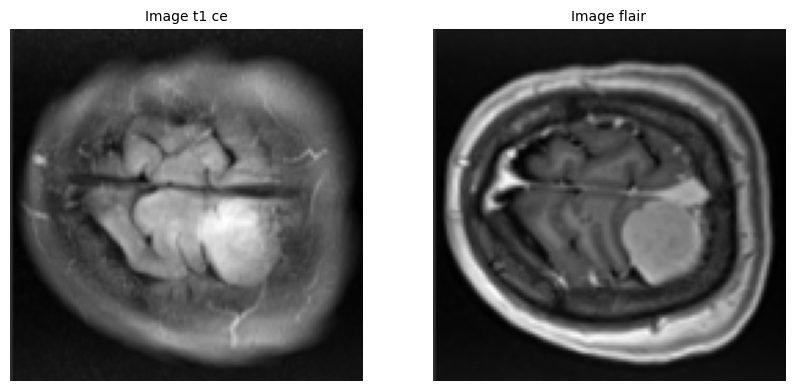

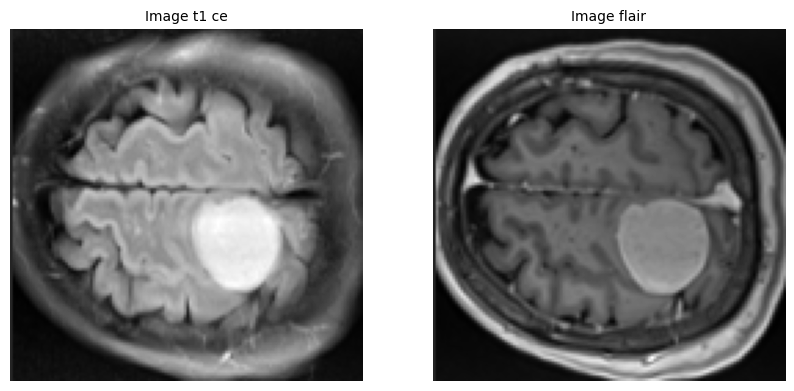

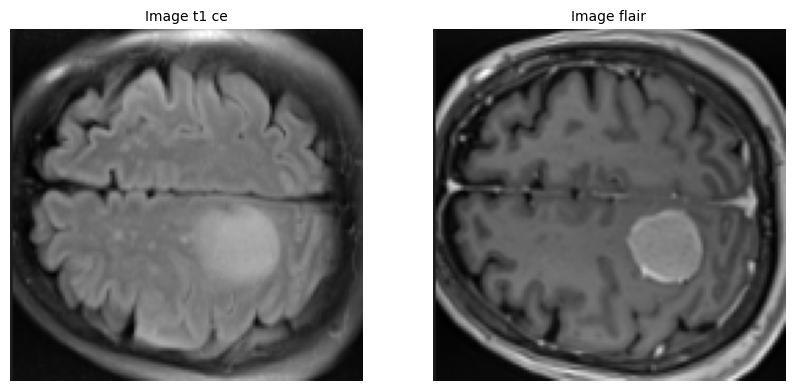

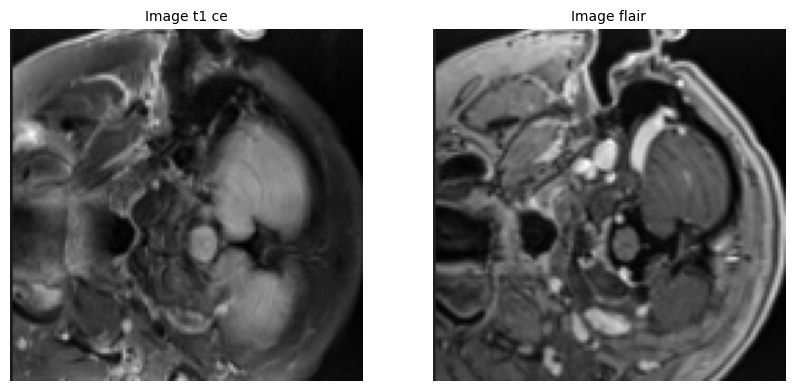

In [192]:
## On va selectionner les slides d'interets manuellement

slice=[70,80,90,197]
print(combined_x.shape)

for n_slice in slice:
    # Création d'une figure avec 1 ligne et 2 colonnes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Affichage de l'image t1
    axs[0].imshow(combined_x[n_slice,:,:,0], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Image t1 ce" ,fontsize=10)

    # Affichage de l'image flair
    
    axs[1].imshow(combined_x[n_slice,:,:,1], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Image flair", fontsize=10)


    # Affichage du tableau avec les deux cellules
    plt.show()

In [193]:
#### On redimensionne des slides 70 à 197
combined_x=combined_x[70:198,:,:] 
print(combined_x.shape)

(128, 128, 128, 2)


In [ ]:
#### On sauvegarde le patient
np.save('/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/DataBase_IA/input_128/patient_test.npy', combined_x)